# Black-Litterman Portfolio's Theory #

### Practical Example ###

In [2]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_financial_data
from portfolios_toolkit import calculate_analytics

In [3]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL", mkt_cap=True)

# Amazon Data
df_2 =  import_financial_data("AMZN", mkt_cap=True)

# Meta Data
df_3 =  import_financial_data("META", mkt_cap=True)

# Microsoft Data
df_4 =  import_financial_data("MSFT", mkt_cap=True)

In [4]:
# Create the joint dataframe
df_data = pd.DataFrame()

# Columns will be the Adjusted Close Price
df_data['AAPL'] = df_1['adj_close']
df_data['AMZN'] = df_2['adj_close']
df_data['META'] = df_3['adj_close']
df_data['MSFT'] = df_4['adj_close']

# Drop Missing Data
df_data = df_data.dropna()

df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT
Date,,,,
2015-01-02,0.103109,0.122536,0.109293,0.104190
2015-01-05,-2.817159,-2.051731,-1.606119,-0.930282
2015-01-06,0.009412,-2.283332,-1.347325,-1.457097
2015-01-07,1.402221,1.059975,0.000000,1.270537
2015-01-08,3.842227,0.683600,2.659225,2.941813
...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686
2024-10-24,-0.082337,0.904120,0.725576,0.030617


In [5]:
# Theoretically we could use the average as the expected returns (these are daily returns)
expected_returns = df_returns.mean() 

expected_returns

AAPL    0.103109
AMZN    0.122536
META    0.109293
MSFT    0.104190
dtype: float64

In [6]:
# The volatility is calculated with the standard deviations
volatility = df_returns.dropna().std()

volatility

AAPL    1.804141
AMZN    2.064870
META    2.370595
MSFT    1.714066
dtype: float64

In [7]:
# Covariance Matrix
cov_matrix = df_returns.dropna().cov()

cov_matrix

,AAPL,AMZN,META,MSFT
AAPL,3.254923,2.072320,2.253791,2.113185
AMZN,2.072320,4.263688,2.893688,2.324754
META,2.253791,2.893688,5.619722,2.365815
MSFT,2.113185,2.324754,2.365815,2.938023


In [9]:
# Create the Market Capitalization 
df_mktcap = pd.DataFrame()

df_mktcap['AAPL'] = np.sqrt(df_1['mkt_cap'])
df_mktcap['AMZN'] = np.sqrt(df_2['mkt_cap'])
df_mktcap['META'] = np.sqrt(df_3['mkt_cap'])
df_mktcap['MSFT'] = np.sqrt(df_4['mkt_cap'])

df_mktcap = df_mktcap.dropna()

df_mktcap

,AAPL,AMZN,META,MSFT
Date,,,,
2015-01-02,8.077314e+05,3.715810e+05,4.676608e+05,6.236828e+05
2015-01-05,7.977178e+05,3.681109e+05,4.638901e+05,6.197717e+05
2015-01-06,8.012513e+05,3.702082e+05,4.607544e+05,6.181403e+05
2015-01-07,7.997233e+05,3.692838e+05,4.607544e+05,6.154675e+05
2015-01-08,7.887963e+05,3.652831e+05,4.668405e+05,6.122785e+05
...,...,...,...,...
2024-10-15,1.893686e+06,1.411031e+06,1.217849e+06,1.782778e+06
2024-10-16,1.873101e+06,1.392349e+06,1.207962e+06,1.776700e+06
2024-10-17,1.872330e+06,1.398629e+06,1.208109e+06,1.776972e+06


In [10]:
# Create the Market Capitalization Weights

total_market_cap = df_mktcap.sum(axis=1)  # Horizontal Sum because we got a Time Series

df_mktcap_weights = df_mktcap.div(total_market_cap, axis = 0)

df_mktcap_weights

,AAPL,AMZN,META,MSFT
Date,,,,
2015-01-02,0.355726,0.163645,0.205958,0.274671
2015-01-05,0.354622,0.163642,0.206220,0.275516
2015-01-06,0.356056,0.164511,0.204747,0.274686
2015-01-07,0.356188,0.164475,0.205215,0.274122
2015-01-08,0.353214,0.163569,0.209046,0.274171
...,...,...,...,...
2024-10-15,0.300330,0.223783,0.193145,0.282741
2024-10-16,0.299691,0.222772,0.193271,0.284267
2024-10-17,0.299284,0.223565,0.193111,0.284041


In [11]:
# Let us use the last observations since the mean of the portfolio is calculated with the whole story

market_weights = df_mktcap_weights.iloc[-1]

market_weights

AAPL    0.300107
AMZN    0.224015
META    0.192169
MSFT    0.283710
Name: 2024-10-21 00:00:00, dtype: float64

In [12]:
# We can calculate or estimate the Risk Aversion Coefficient using market data, but let us assume it

risk_aversion = 2.5

In [13]:
# Compute implied equilibrium returns

pi = risk_aversion * cov_matrix @ market_weights

pi

AAPL    6.184236
AMZN    6.981695
META    7.689369
MSFT    6.107854
dtype: float64

In [14]:
# Tau adjustment (controls uncertainty of implied returns)
tau = 0.10

pi_adjusted = tau * pi

pi_adjusted

AAPL    0.618424
AMZN    0.698170
META    0.768937
MSFT    0.610785
dtype: float64

In [15]:
# P matrix: 1 view per asset (identity matrix)
P = np.identity(4)

# Q vector: our expected returns relative to the market
Q = np.array([0.01, 0.02, 0.05, 0.03])  # AAPL, AMZN, META, MSFT

In [16]:
# Diagonal Omega matrix: uncertainty of each view
# Often proportional to variance of the assets related to the views
Omega = np.diag(np.diag(P @ cov_matrix @ P.T)) * tau

Omega

array([[0.32549234, 0.        , 0.        , 0.        ],
       [0.        , 0.42636876, 0.        , 0.        ],
       [0.        , 0.        , 0.56197224, 0.        ],
       [0.        , 0.        , 0.        , 0.29380226]])

In [17]:
# Inverse Matrix

inv_tau_sigma = np.linalg.inv(tau * cov_matrix)
inv_omega = np.linalg.inv(Omega)

In [18]:
# Apply Black-Litterman formula

posterior_mean = np.linalg.inv(inv_tau_sigma + P.T @ inv_omega @ P) @ (inv_tau_sigma @ pi + P.T @ inv_omega @ Q)

posterior_mean

array([1.69013358, 1.82837403, 2.03731342, 1.61221541])

In [19]:
# Calculate the Optimal Weights

optimal_weights = np.linalg.inv(cov_matrix) @ (posterior_mean) / risk_aversion

# Normalize weights to sum to 1

optimal_weights /= np.sum(optimal_weights)

optimal_weights

array([0.35067765, 0.20359322, 0.18994244, 0.25578669])

In [20]:
# Calculate the Portfolio Returns and Variance

portfolio_returns = np.dot(optimal_weights, expected_returns)

portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))

portfolio_volatility = np.sqrt(portfolio_variance)

print(f"Expected Portfolio Return: {portfolio_returns:.4f}")
print(f"Portfolio Variance: {portfolio_variance:.6f}")
print(f"Portfolio Volatility (Std Dev): {portfolio_volatility:.4f}")

Expected Portfolio Return: 0.1085
Portfolio Variance: 2.643050
Portfolio Volatility (Std Dev): 1.6257


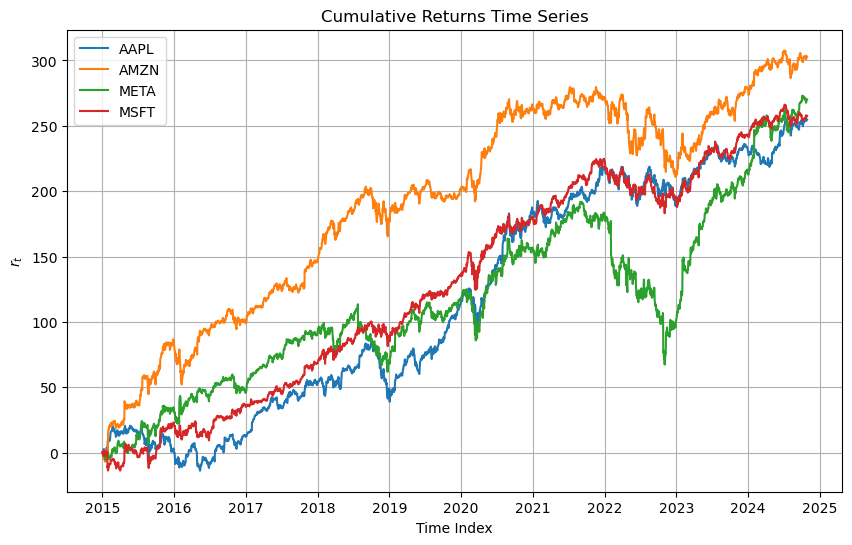

In [23]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('$r_t$')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [24]:
# Calculate the Historical Returns of the Portfolio

portfolio_returns = df_returns @ optimal_weights

portfolio_returns

Date
2015-01-02    0.108515
2015-01-05   -1.948657
2015-01-06   -1.090190
2015-01-07    1.032518
2015-01-08    2.744136
                ...   
2024-10-22    0.735335
2024-10-23   -2.065810
2024-10-24    0.300848
2024-10-25    0.675103
2024-10-28    0.431755
Length: 2472, dtype: float64

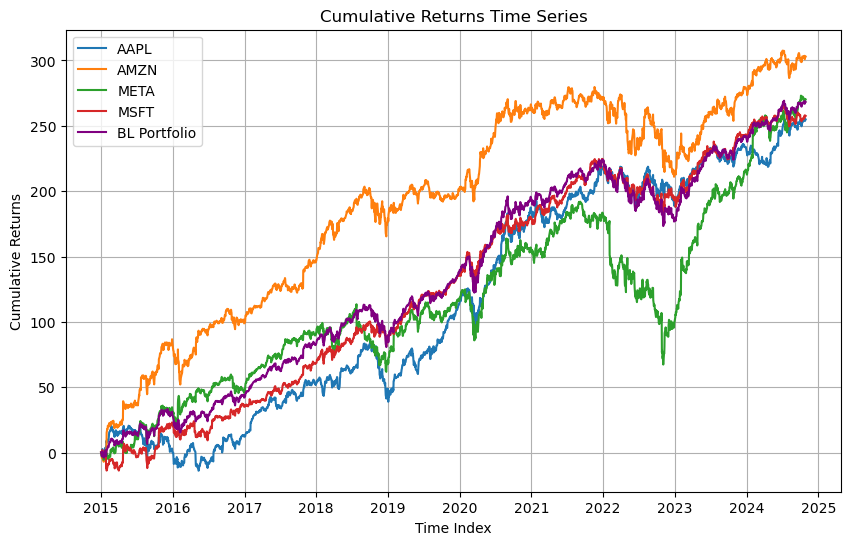

In [25]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns.cumsum(), label=df_returns.columns, alpha=1)
plt.plot(portfolio_returns.cumsum(), label='BL Portfolio', color='purple', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [26]:
# Create the Analytics

df_returns['BL'] = portfolio_returns

df_returns

,AAPL,AMZN,META,MSFT,BL
Date,,,,,
2015-01-02,0.103109,0.122536,0.109293,0.104190,0.108515
2015-01-05,-2.817159,-2.051731,-1.606119,-0.930282,-1.948657
2015-01-06,0.009412,-2.283332,-1.347325,-1.457097,-1.090190
2015-01-07,1.402221,1.059975,0.000000,1.270537,1.032518
2015-01-08,3.842227,0.683600,2.659225,2.941813,2.744136
...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,0.735335
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-2.065810
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.300848


In [27]:
# Now the table
analytics_table = calculate_analytics(df_returns)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,25.983505,28.639845,0.907250,-0.387297,-2.713460
AMZN,30.879190,32.778793,0.942048,-0.561453,-3.061348
META,27.541784,37.632035,0.731871,-0.767361,-3.317563
MSFT,26.255872,27.209956,0.964936,-0.375565,-2.646305
BL,27.345884,25.807917,1.059593,-0.435113,-2.587365
